 # Homework 6
 ### By Franklin Marsh
 ### MATH0154 Computational Statistics
 ### with Prof. Gabe Chandler


 ## Problem 1

Consider generating data from a some density $f(x)$ (pick something nice so that you can use both the 'rdist' and 'ddist' functions in R to get your random sample and compute the truth, respectively, easily).  Based on a random sample of size $n$, we would like to estimate this function.  We will use a kernel smoother, which you will write.  Use a truncated normal distribution as your kernel function.\\[5pt]

We need to specify the bandwidth for our kernel smoother.  Consider 3 ideas from class for estimating this quantity:

First, we will define our kernel. We will use a package to create truncated normal distributions.

In [178]:
#install.packages('truncnorm', repos="http://cran.rstudio.com/")
library(truncnorm)

kernel <- function(x, mu, bw) {
    #
    # function that returns a kernel given a value, mean, and bandwidth
    # 
    # Args:
    #    x: value at which to evaluate the truncated normal pdf
    #    mu: mean of the truncated normal pdf
    #    bw: standard deviation of the truncated normal pdf
    # Returns:
    #    y: the truncated normal evaluated at x
    
    #truncated normal distribution kernel
    return(dtruncnorm(x, a = c(-2), b = c(2), mean = mu, sd = bw))
}

Here is a plot of a truncated normal distribution!

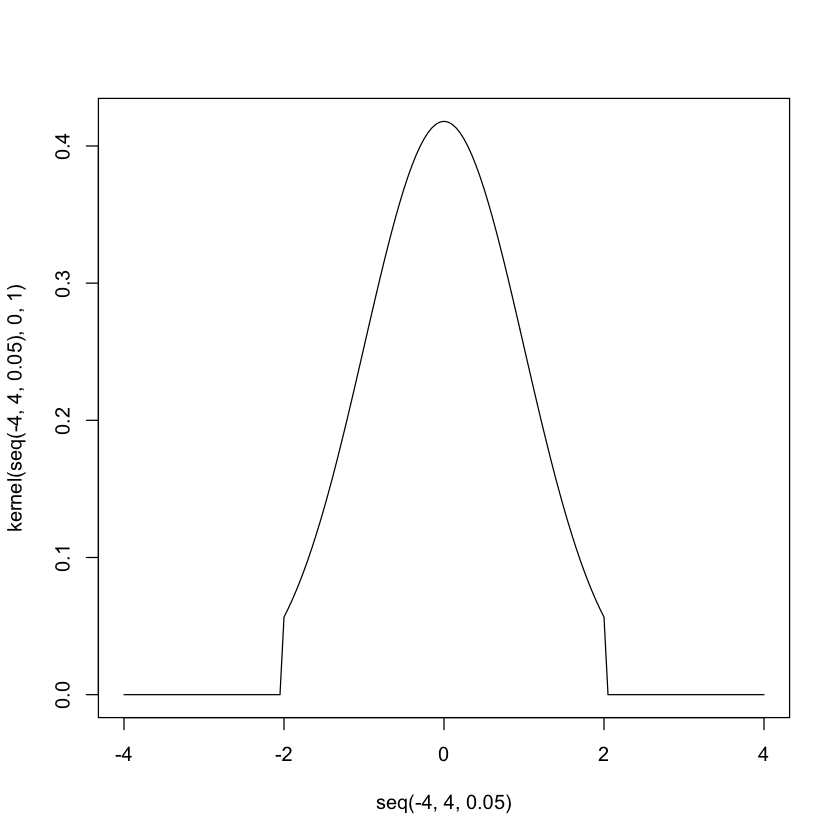

In [141]:
plot(seq(-4, 4, 0.05),kernel(seq(-4, 4, 0.05), 0, 1), type = 'l')

In this next cell, we construct the KDE by summing all of the little kernels!

In [179]:
KDensity <- function(x_vals, obs, bw) {
    #
    # function performs a kernel density estimate given values to evaluate, observations, and a bandwidth
    # 
    # Args:
    #    x_vals: value at which to evaluate the kernel density estimate
    #    obs: a vector of the observations
    #    bw: bandwidth of the kernel that is being used
    # Returns:
    #    y: the kernel density evaluated at x
    
    kernels <- c()
    y_vals <- c()
    
    i <- 1 # set observation counter to zero
    j <- 1 #set abcissa counter to zero
    
    for (x in x_vals) {
         
        for (ob in obs) {
            kernels[i] <- dtruncnorm(x, a = c(-4), b = c(4), mean = ob, sd = bw)
            i <- i + 1
        }
        
        y_vals[j] <- sum(kernels)
        
        j <- j + 1
        i <- 1
    }
    return(y_vals/length(obs))
}

In [180]:
my_obs <- rnorm(100) #draw 100 random normals
my_abcissa <- seq(-4,4,0.01) #create an abcissa to plot on

In the next cell, I plot the KDE for a variety of bandwidths. The true PDF is plotted in as dashed red line. In the next parts, we will create an intelligent way to best estimate this bandwidth.

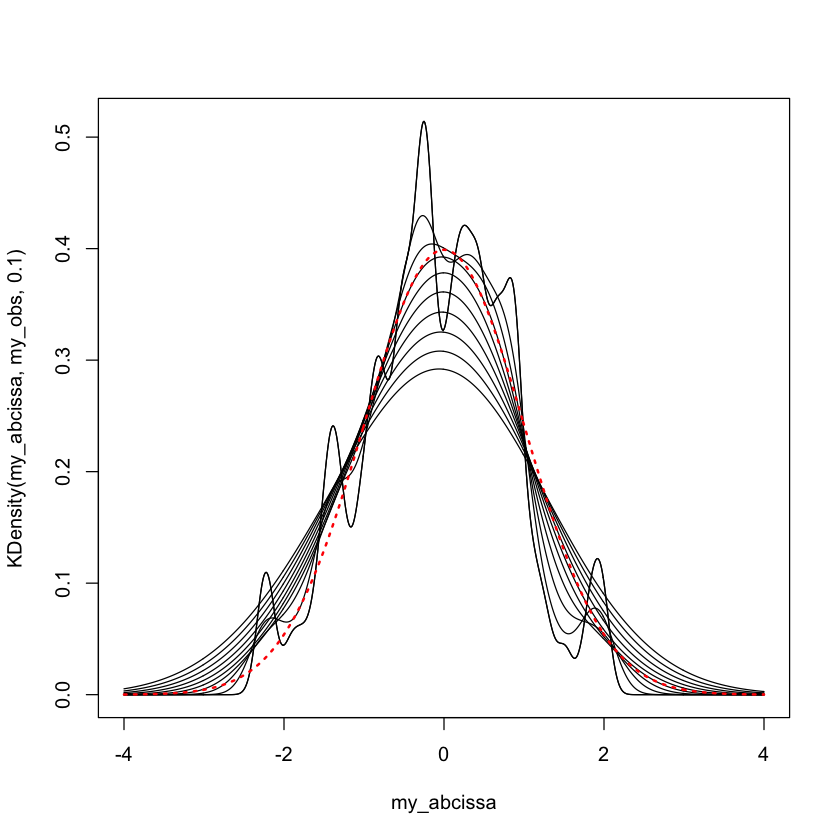

In [181]:
plot(my_abcissa,KDensity(my_abcissa, my_obs, 0.1), type = 'l')

for (bandwidth in seq(0.1, 1.0, 0.1)) {
    lines(my_abcissa,KDensity(my_abcissa, my_obs, bandwidth), type = 'l')
}

#create a plot of all the kde's superposed
lines(my_abcissa, dnorm(my_abcissa), col = 'red', lwd = 2, lty = 3)

a) leave one out cross validation where we try to maximize the likelihood (so we look at $\prod \hat{f}_h^{-i}(x_i)$)\\

b) the same as a, but instead of a product, use the sum. 

In the next cell, I have written the cross-validation code.

In [190]:
CV <- function(my_obs, bandwidth, kind = 'sum') {
    #
    # function that performs leave-one-out cross validaton for kernel-density bandwidth
    # 
    # Args:
    #    my_obs: observations on which to perform KDE
    #    bw: bandwidths of the kernels that are being used, should be a seq()
    #    kind: cost function to use. 'sum' for additive, 'prod' for multiplicative
    # Returns:
    #    out: the CV sum or product evaluated at each bandwidth
    
    sum_terms <- c()
    
    output <- c()
    j <- 1 
    
    if (kind == 'sum') {
    
        for (bw in bandwidth) {
    
            for (i in (1:length(my_obs))) {
                sum_terms[i] <- KDensity(my_obs[i], my_obs[-i], bw)
    
            }
    
            output[j] <- sum(sum_terms)
            j <- j + 1
        
        }
        
    }
    
    else if (kind == 'prod') {
    
        for (bw in bandwidth) {
    
            for (i in (1:length(my_obs))) {
                sum_terms[i] <- KDensity(my_obs[i], my_obs[-i], bw)
    
            }
    
            output[j] <- prod(sum_terms)
            j <- j + 1
        
        }
        
    }
    
    else {
        stop("Invalid Type")
    }
    
    return(list(bandwidth,output/max(output)))
}


c) Training the data on a random half of the data, testing it on the other half (via a or b) and then scaling down your bandwidth, based on the theoretical optimal bandwidth rate (the bandwidth should be of the order $n^{-1/5}$)\\
Compare all of these to the optimal bandwidth, defined here to be the bandwidth for which the estimate $f_h(x)$ minimizes $\int |\hat{f}_h(x)-f(x)|dx.$ (Once you have written a code to do kernel density estimation, feel free to use the {\it density} function in R to run the simulations to speed up your code.) 

In [182]:
TrainTestSplit <- function(obs, test_size) {
    #
    # function splits observations into a trainign set and a testing set
    # 
    # Args:
    #    obs: observations on which to perform KDE
    #    test_size: fraction of the observations that will be sorted into the testing set
    # Returns:
    #    out: a list where the first entry is the training set, and the second is the testing set
    
    split_frac <- as.integer(1.0/test_size)
    
    test_i <- sample((1:length(obs)),length(obs)/split_frac)
    train_i <- (1:length(obs))[-test_i]

    if ((sum(test_i) + sum(train_i)) == sum(1:length(obs))) {
        train <- obs[train_i]
        test <- obs[test_i]
    }

    else {
        stop("Error, sum of split parts did not equal some of the whole")
    }
    
    return(list(train,test))
}

In [183]:
my_split <- TrainTestSplit(my_obs, 0.5) #split the training and testing data

In [184]:
SplitCV <- function(train, test, bandwidth, kind = 'sum') {
    #
    # function splits observations into a trainign set and a testing set
    # 
    # Args:
    #    train: vector of training set
    #    test: vector of testing set
    #    bandwidth: the sequence of bandwidths to test
    #    kind: cost function to use. 'sum' for additive, 'prod' for multiplicative
    # Returns:
    #    out: the CV sum or product evaluated at each bandwidth
        
    output <- c()
    j <- 1 
    
    if (kind == 'sum') {
    
        for (bw in bandwidth) {
        
            output[j] <- sum(abs(KDensity(test, train, bw)))
        
            j <- j + 1
        
    }
            
    }
    
    else if (kind == 'prod') {
    
        for (bw in bandwidth) {
        
            output[j] <- prod(abs(KDensity(test, train, bw)))
        
            j <- j + 1
        
    }
    
    }
    
    #modify the bandwidth according to the scaling relationship
    mod_bandwidth <- ((length(train) + length(test))/length(train))^(-1.0/5.0)*bandwidth
    
    return(list(mod_bandwidth,output/max(output)))
    
}

In [191]:
bw_range <- seq(0.01,1.0,0.01) #the range of bandwidths that we will test
sum_split_cv <- SplitCV(my_split[[1]], my_split[[2]], bw_range, kind = 'sum') 
prod_split_cv <- SplitCV(my_split[[1]], my_split[[2]], bw_range, kind = 'prod')
sum_cv <- CV(my_obs, bw_range, kind = 'sum')
prod_cv <- CV(my_obs, bw_range, kind = 'prod')

To find the "Correct" KDE bandwidth, we will estimate the $f_h(x)$ minimizes $\int |\hat{f}_h(x)-f(x)|dx.$. $f(x)$ here is just the standard normal pdf.

In [192]:
TrueBandwidth <- function(x_range, bandwidth, obs, truth) {
    #
    # function to find the correct bandwidth using the true pdf
    #
    # Args:
    #    x_range: vector of discreet x-values to evaluate both the KDE and the pdf at
    #    bandwidth: the range of bandwidths for which to perform this test
    #    obs: the observations used to construct the KDE
    #    truth: the true pdf that the observations are drawn from
    # Returns:
    #    output: a dataframe of bandwidth, and the difference that we seek to minimize
    
    output <- c()
    j <- 1

    for (bw in bandwidth) {
        
        output[j] <- sum(abs(KDensity(x_range, obs, bw) - truth(x_range)))
        
        j <- j + 1
        
    }
    
    output <- output/max(output)
    
    return(data.frame(bandwidth, output))
            
    }


In [187]:
true_bandwidth <- TrueBandwidth(my_abcissa, bw_range, my_obs, dnorm) #calculate a true bandwidth

In [189]:
true_bw <- head(true_bandwidth[order(true_bandwidth$output),],1)$bandwidth
print(true_bw)

[1] 0.4


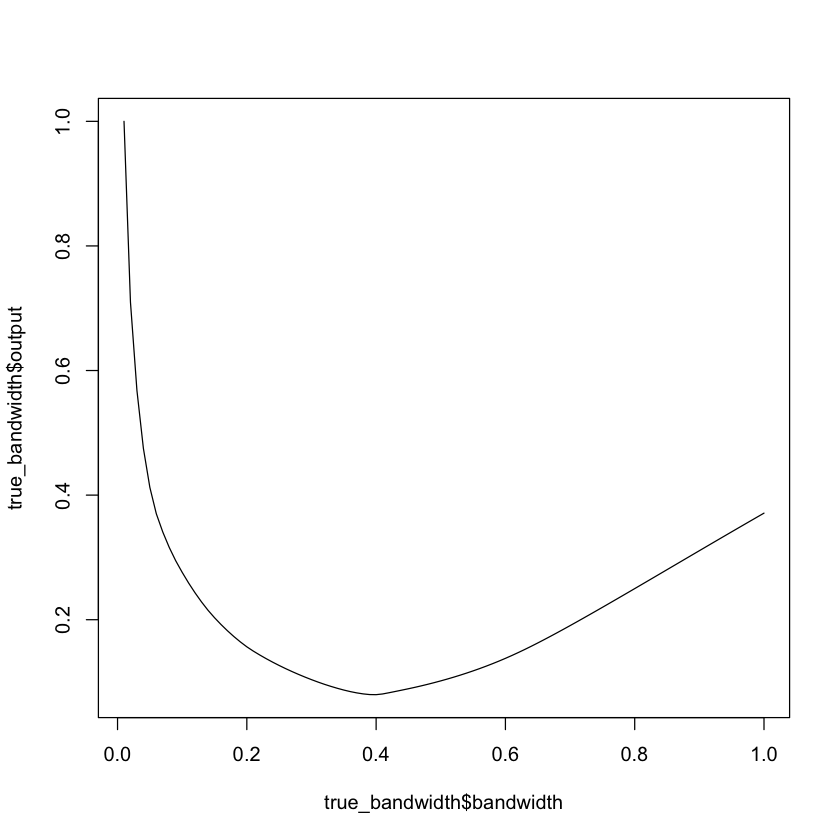

In [193]:
plot(true_bandwidth$bandwidth,true_bandwidth$output, type ='l') 

In the next cell, we will plot the support for each value of bandwidth as a function of bandwith, for all of the estimators that we have proposed.

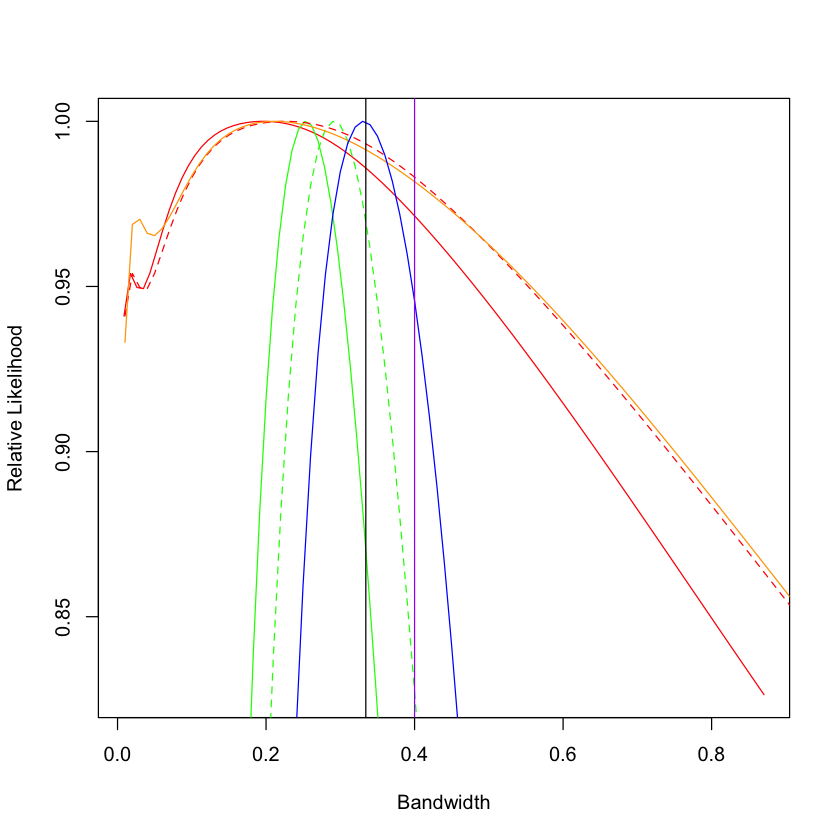

In [196]:
#initialize the plot and use the sum estimator from part c
plot(sum_split_cv[[1]], sum_split_cv[[2]], type = 'l', col = 'red',
    xlab = 'Bandwidth', ylab = 'Relative Likelihood')

#use the product estimator from part c
lines(prod_split_cv[[1]], prod_split_cv[[2]], type = 'l', col = 'green')

#plot the unscaled recommendation from part c
lines(bw_range, sum_split_cv[[2]], type = 'l', col = 'red', lty = 2)
lines(bw_range, prod_split_cv[[2]], type = 'l', col = 'green', lty = 2)

#plot the bandwidth recommendations for parts a and b
lines(sum_cv[[1]], sum_cv[[2]], type = 'l', col = 'orange')
lines(prod_cv[[1]], prod_cv[[2]], type = 'l', col = 'blue')

abline(v = as.numeric(density(my_obs)$bw), col = 'black') #the estimate that R uses
abline(v = true_bw, col = 'purple')

1. The black vertical line is the estimate as returned by R's density function. 

2. The purple vertical line is the "true" density, computed using the normal pdf.

3. The blue curve is the leave-one-out cross-validated product-cost curve.
4. The orange curve is the leave-one-out cross-validated sum-cost curve.

For the next two cases, the dotted line shows the initial bandwidth (estimated using half of the observations) while the solid line shows the transformed ($h \propto n^{-\frac{1}{5}}$)

5. The green curves are the split cross-validated product-cost curves.
6. The red curves are the split corss-validated sum-cost curves.

We can see some general characteristics of the estimators:

1. R's density function is probably using leave-one-out cross-validation and a product-cost function.

2. The sum cost functions produce smaller estimations of the bandwidth in all cases.

3. The True bandwidth is larger than all of the estimates.

 ## Problem 2

Consider seeing data from a density defined as follows:
\begin{eqnarray}
f(x)=\left\{ \nonumber
\begin{array}{ll}
0.05  & \mbox{for }|x|\leq0.13\\
0.987[\phi(x)+\phi(|x|-0.13)] & \mbox{for }0.13<|x|<0.26\\
0.987\phi(x) & \mbox{for }|x|\geq 0.26,\\
\end{array}\right.
\end{eqnarray}

where $\phi(x)$ is the standard normal pdf.

a. Use acceptance sampling to generate from this density.



In [1]:
g <- function(x) {
    #
    # produce pdf of candidate normal distribution
    #
    # Args:
    #    x: evaluate normal at this value
    # Returns:
    #    y: value of the pdf at x
    
    return(dnorm(x))
}

f <- function(x) {
    #
    # produce pdf of target "hole-y" distribution
    #
    # Args:
    #    x: evaluate target pdf at this value
    # Returns:
    #    y: value of the target pdf at x
    
    output <- c()
    j <- 0
    
    for (i in x) {
        j <- j + 1
        
        if (abs(i) < 0.13) {
            output[j] <- 0.05
        }
    
        else if (abs(i) < 0.26) {
            output[j] <- (0.987*(dnorm(i) + dnorm(abs(i) - 0.13)))
        }
    
        else {
            output[j] <- (0.987*(dnorm(i)))
        }
        
    }
    
    return(output)
    
}

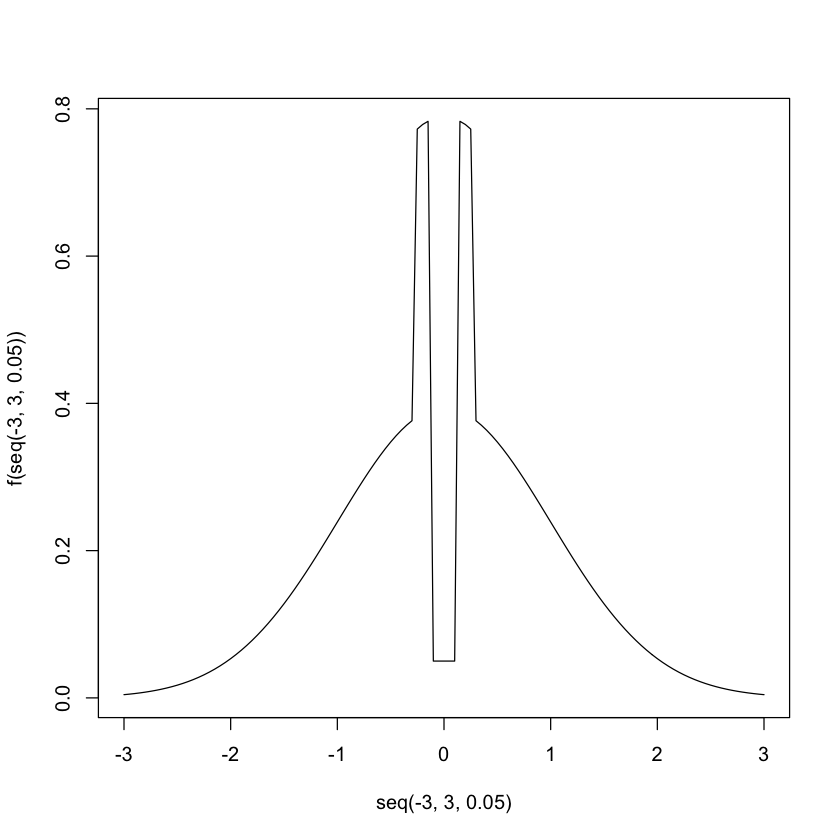

In [2]:
plot(seq(-3,3, 0.05),f(seq(-3,3, 0.05)), type = 'l')

In [11]:
MaskingDraw <- function(maskdraw, maskpdf, goalpdf, c, n_iters) {
    
    # Draw from pdf (goalpdf) using the masking technique
    # 
    # Args:
    #     maskdraw: a function that draws from the masking dist.
    #     maskpdf: a function that returns the pdf of the masking dist when given an x.
    #     goalpdf: the pdf of the function that we are trying draw from
    #     c: the c normalizing constant for maskpdf and goalpdf
    #     n_iters: number of points that we want to draw
    #
    # Returns:
    #     out: randoom numbers like they were drawn from goalpdf
    
    out <- c(NaN) #initialize empty output
    i <- 0
    
    while (length(out[!is.na(out)]) < n_iters) {
        
        i <- i + 1
        
        pull <- maskdraw(1) #the initial value we are pulling from the masking distribution
        crit <- (goalpdf(pull))/(c*maskpdf(pull))
                
        U <- runif(1)
        
        if (U <= crit) {
            out[i] <- pull
            }
    }
    return(out[!is.na(out)])
    }

FindC <- function(maskpdf, targetpdf, prange = seq(-3,3,0.01), by = 0.01) {
    
    # Finds the normalizing coefficient c for drawing using the masking technique
    #
    # Args:
    #     maskpdf:
    #     targetpdf:
    #     param1:
    #     prange:
    #     by:
    # Returns:
    #     c: normalizing coefficient
    
    grid <- seq(min(prange),max(prange), by)
    
    c <- max((targetpdf(grid))/(maskpdf(grid)))
    
    return(c)
}

In [4]:
c <- FindC(g, f) #find the acceptance-rejection sampling constant

In [12]:
#draw the sample of 500 points
sample <- MaskingDraw(rnorm, g, f, c, 500)

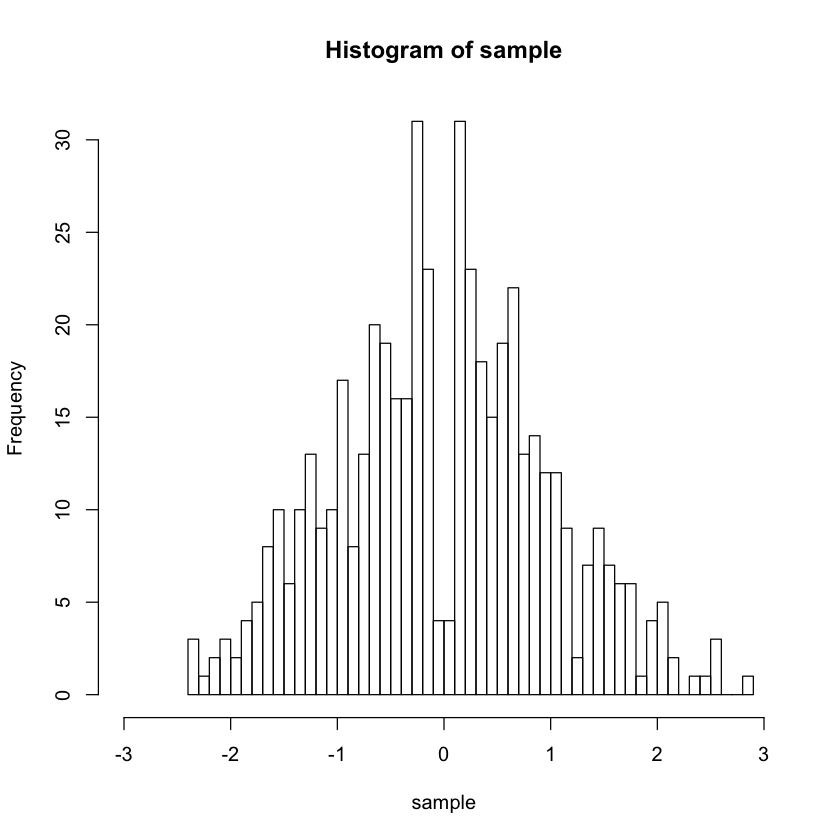

In [13]:
hist(sample, breaks = 50, xlim = c(-3,3))

b. See if density estimation using optimal bandwidths (you can just use the default in the R density function to do this) can detect the hole in the middle, with $n=500$.

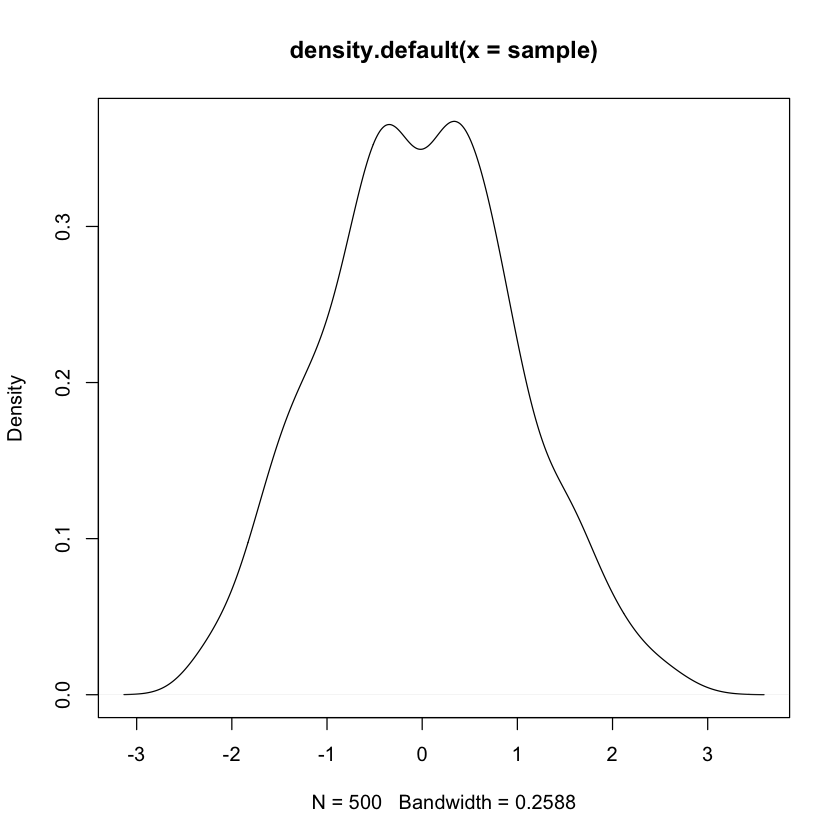

In [14]:
plot(density(sample))

The estimate above does capture a small decrease in the density near $x = 0$, however, the true extent of the bi-modality is not well captured. In the next cell, we will derive a statistic that can measure if the distribution is normal.

c. Suggest some quantity that is better than density estimation at detecting the bi-modality of this density based on a random sample and present some simulations to show this. 



I suggest the statistic of the number of observations within a distance $c$ from the center, divided by the total number of observations:

In [64]:
NormStat <- function(obs, center_range) {
    #
    # Compute a statistic that is the fraction of observations within a certain distance from the origin
    # 
    # Args:
    #    obs: observations to compute the statistic for
    #    center_range: the range of possible center widths to compute the statistic for
    # Returns:
    #    statistic: a dataframe of the statistic evaluated for each possible center width
    
    output <- c()

    i <- 0
    
    for (center in center_range) {
        
        i <- i + 1
        
        in_c <- c() #initialize vecotr to store observations inside of center
        out_c <- c() #initialize vecotr to store observations outside of center
        
        j <- 0
        
        for (ob in obs) {
            
            j <- j + 1 
            
            if (abs(ob) <= center) {
                in_c[j] <- ob
            }
            
            else if (abs(ob) > center) {
                out_c[j] <- ob
            }
            
        }
                
        output[i] <- length(in_c[!is.na(in_c)])/length(obs)
    }
    
    return(data.frame(center_range, output))
}

In [111]:
center_range <- seq(0.01,1,0.01)

test_curve <- NormStat(sample, center_range)
reference_curve <- NormStat(rnorm(10000), center_range)

test_curve$diff <- c(test_curve$output - reference_curve$output)

best_c <- head(test_curve[order(test_curve$diff),],1)$center_range #find the best guess for the hole width
test_statistic <- head(test_curve[order(test_curve$diff),],1)$output #find the best guess for the hole width

We record the fraction of observations in the center as a function of center width, for our "hole-y" distribution, as well as for the normal distribution. When the center width equals the true center width, the fraction should be at a minimum. We can return this minimum value as the best estimate for the center width.

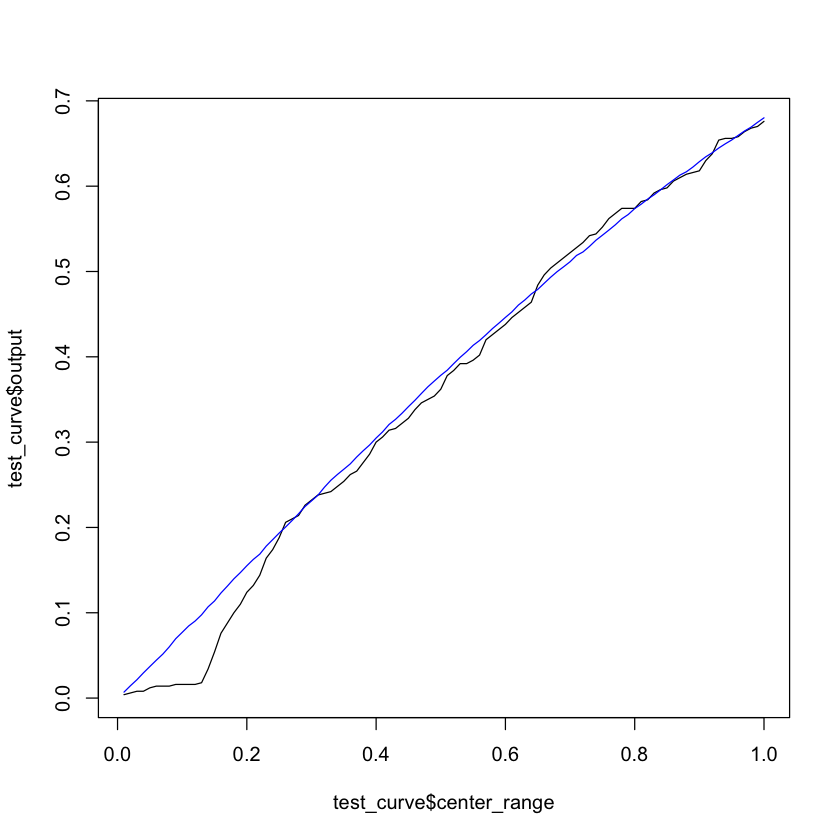

In [84]:
plot(test_curve$center_range, test_curve$output, type = 'l')
lines(reference_curve$center_range, reference_curve$output, col = 'blue')

We can see the expected value of this statistic for the normal distribution as the smooth curve plotted in blue. The curve in black is the bumpier curve that is the statistic as computed on our observations.

Our best estimate of the value of the center width is the value that maximizes the curve below:

[1] 0.13


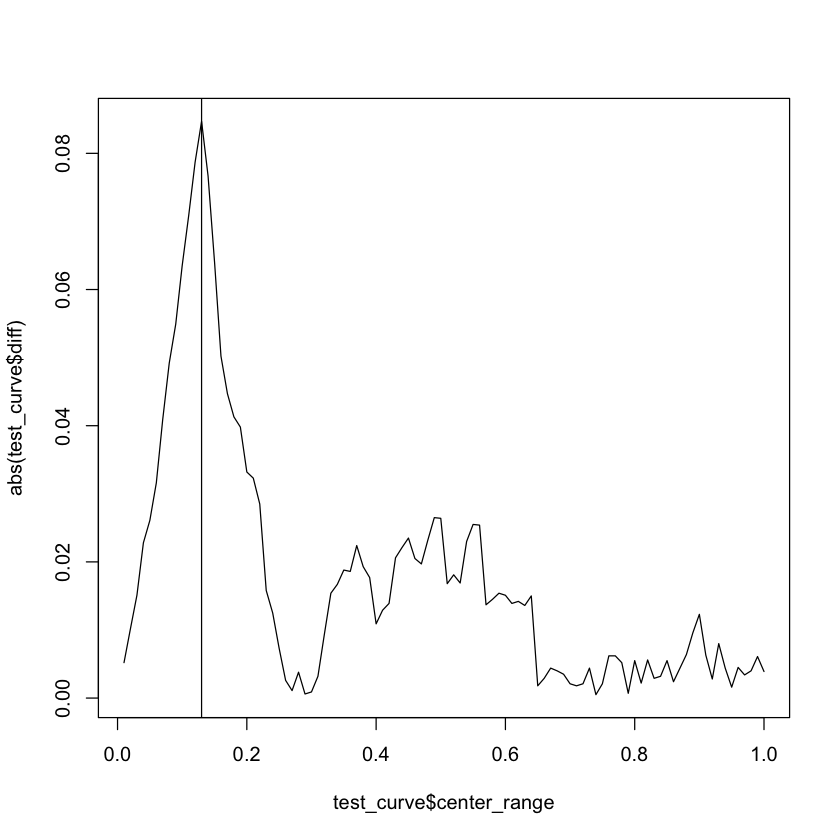

In [199]:
print(best_c)
plot(test_curve$center_range, abs(test_curve$diff), type = 'l')
abline(v = best_c)

We need to calculate the stastical significance of the hole we just detected. To do this, we will simulate the fraction of observations in the center for a random normal, 1000 times. We will then compare the test value to this distribution to see if it is a significant outlier.

In [107]:
HoleSig <- function(best_c, obs, n_sims) {
    #
    # function to compute the evidence for a hole of width best_c in a normal distribution
    #
    # Dependencies:
    #    function: NormStat
    # 
    # Args:
    #    best_c: the candidate hole width
    #    obs: samples drawn from the candidate "hole-y" distribution
    #    n_sims: number of simulations to perform
    # Returns:
    #    sims: vector of simulated statistic values
    
    i <- 0
    sims <- c()
    
    for (i in (1:n_sims)) {
        sims[i] <- NormStat(rnorm(length(obs)), best_c)$output
    }
    
    return(sims)
}

In [200]:
my_sims <- HoleSig(best_c, sample, 1000)
print('Significance Levels:')
print(quantile(my_sims, c(0.001,0.01,0.05))) #display the 3-sigma significance level 
print('Test Statistic:')
print(test_statistic)

[1] "Significance Levels:"
    0.1%       1%       5% 
0.063994 0.070000 0.082000 
[1] "Test Statistic:"
[1] 0.018


The test statistic of 0.018 is much less than the 0.1% simulated value of 0.068. Thus, we can say with over 3-sigma certainty that we have a hole in the center of this distribution with a width of $\approx 0.13$. The previous simulation assumes a hole that is centered about 0. If we cannot assume that the hole is centered, then we must additionally search for the hole center location using a grid search.